In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision import models as md
from torch import nn
from torch.nn import functional as F
import re
import math
import collections
from functools import partial
from torch.utils import model_zoo
from sklearn import metrics
from collections import Counter
import json
from efficientnet_pytorch import EfficientNet
from utils import *

In [3]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
SEED = 2019
seed_everything(SEED)

In [4]:
current_time = get_BJ_time()
print(current_time)

0823_18-21-16


# Reading data and Basic EDA(Exploratory Data Analysis)

Here I am going to open the dataset with pandas, check distribution of labels.

In [5]:
df_2019_cv = pd.read_csv('../input/aptos-data-split/df_2019_cv.csv')

test_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

In [6]:
bs = 24 #smaller batch size is better for training, but may take longer
sz = 256  # get model input size
# sz = EfficientNet.get_image_size(model_name)  # get model input size
tfms = get_transforms(do_flip=True,flip_vert=True, max_rotate=0, max_zoom=1.2, max_warp=0)

# Training (Transfer learning)
The Kaggle competition used the Cohen's quadratically weighted kappa so I have that here to compare. This is a better metric when dealing with imbalanced datasets like this one, and for measuring inter-rater agreement for categorical classification (the raters being the human-labeled dataset and the neural network predictions). Here is an implementation based on the scikit-learn's implementation, but converted to a pytorch tensor, as that is what fastai uses.

In [7]:
def qk(y_pred, y):
    k = torch.tensor(cohen_kappa_score(torch.round(y_pred), y, weights='quadratic'), device='cuda:0')
    k[k != k] = 0
    k[torch.isinf(k)] = 0
    
    return k

## Fold 1

In [16]:
data1 = (ImageList.from_df(df=df_2019_cv,path='../input/aptos2019-blindness-detection',cols='id_code', folder='train_images_ben_preprocessing_sigmaX10', suffix='.png')
        .split_from_df("is_valid1")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

model_name = 'efficientnet-b5'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

learn = Learner(data1, 
                model, 
                path = ".",
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = '../output/models/')

learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

learn.load("efficientnet-b5_0812_22-06-45_stage1")

Loaded pretrained weights for efficientnet-b5


Learner(data=ImageDataBunch;

Train: LabelList (2929 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,2.0,2.0,2.0,2.0
Path: ../input/aptos2019-blindness-detection;

Valid: LabelList (733 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,4.0,1.0,0.0,0.0
Path: ../input/aptos2019-blindness-detection;

Test: LabelList (1928 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: ../input/aptos2019-blindness-detection, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleL

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-04
Min loss divided by 10: 9.12E-08


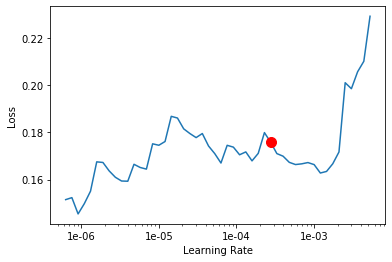

In [18]:
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [19]:
model_save_name = "{}_{}_stage2_f1".format(model_name, current_time)
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(40, 8e-7, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time
0,0.180852,0.210229,0.894505,00:44
1,0.177500,0.214773,0.896927,00:44
2,0.165568,0.217074,0.898306,00:44
3,0.175393,0.216022,0.898471,00:44


Better model found at epoch 0 with valid_loss value: 0.21022926270961761.
Epoch 4: early stopping
Model save as: efficientnet-b5_0820_01-32-30_stage2_f1


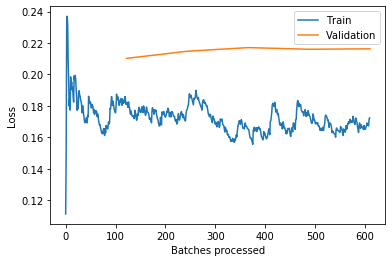

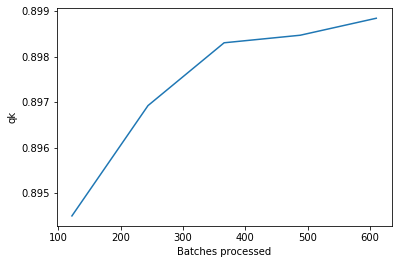

In [20]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [21]:
learn.load(model_save_name)

Learner(data=ImageDataBunch;

Train: LabelList (2929 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,2.0,2.0,2.0,2.0
Path: ../input/aptos2019-blindness-detection;

Valid: LabelList (733 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,4.0,1.0,0.0,0.0
Path: ../input/aptos2019-blindness-detection;

Test: LabelList (1928 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: ../input/aptos2019-blindness-detection, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleL

## Fold 2

In [8]:
data1 = (ImageList.from_df(df=df_2019_cv,path='../input/aptos2019-blindness-detection',cols='id_code', folder='train_images_ben_preprocessing_sigmaX10', suffix='.png')
        .split_from_df("is_valid2")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

model_name = 'efficientnet-b5'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

learn = Learner(data1, 
                model, 
                path = ".",
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = '../output/models/')

learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

learn.load("efficientnet-b5_0812_22-06-45_stage1")

Loaded pretrained weights for efficientnet-b5


Learner(data=ImageDataBunch;

Train: LabelList (2929 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,4.0,1.0,0.0,0.0
Path: ../input/aptos2019-blindness-detection;

Valid: LabelList (733 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,2.0,2.0,2.0,2.0
Path: ../input/aptos2019-blindness-detection;

Test: LabelList (1928 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: ../input/aptos2019-blindness-detection, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleL

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


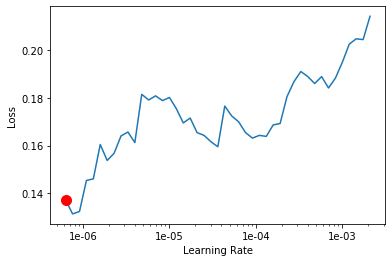

In [13]:
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [14]:
model_save_name = "{}_{}_stage2_f2".format(model_name, current_time)
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(40, 7e-7, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time
0,0.194774,0.207613,0.873244,00:44
1,0.196066,0.207651,0.873037,00:44
2,0.190646,0.207670,0.874306,00:44
3,0.183166,0.207906,0.873055,00:44


/users/liukanglong/.conda/envs/test/lib/python3.6/site-packages/sklearn/metrics/classification.py:576: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


Better model found at epoch 0 with valid_loss value: 0.20761297643184662.
Epoch 4: early stopping
Model save as: efficientnet-b5_0820_22-13-07_stage2_f2


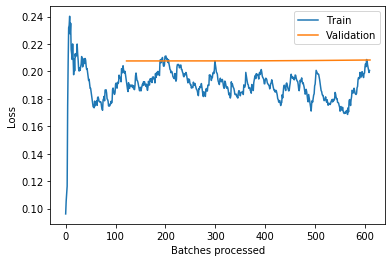

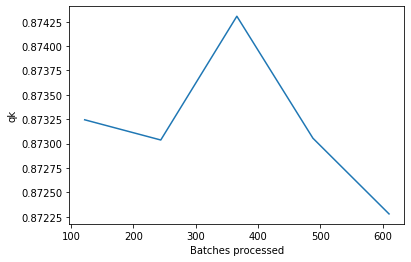

In [15]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [16]:
learn.load(model_save_name)

Learner(data=ImageDataBunch;

Train: LabelList (2929 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,4.0,1.0,0.0,0.0
Path: ../input/aptos2019-blindness-detection;

Valid: LabelList (733 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,2.0,2.0,2.0,2.0
Path: ../input/aptos2019-blindness-detection;

Test: LabelList (1928 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: ../input/aptos2019-blindness-detection, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleL

## Fold 3

In [23]:
data1 = (ImageList.from_df(df=df_2019_cv,path='../input/aptos2019-blindness-detection',cols='id_code', folder='train_images_ben_preprocessing_sigmaX10', suffix='.png')
        .split_from_df("is_valid3")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

model_name = 'efficientnet-b5'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

learn = Learner(data1, 
                model, 
                path = ".",
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = '../output/models/')

learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

learn.load("efficientnet-b5_0812_22-06-45_stage1")

Loaded pretrained weights for efficientnet-b5


Learner(data=ImageDataBunch;

Train: LabelList (2929 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,4.0,1.0,0.0,0.0
Path: ../input/aptos2019-blindness-detection;

Valid: LabelList (733 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
1.0,1.0,1.0,2.0,2.0
Path: ../input/aptos2019-blindness-detection;

Test: LabelList (1928 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: ../input/aptos2019-blindness-detection, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleL

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 1.20E-04


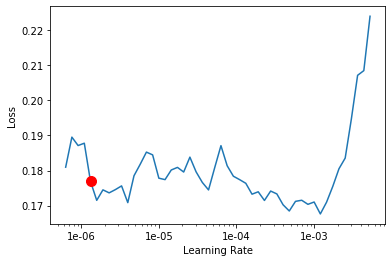

In [32]:
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [29]:
model_save_name = "{}_{}_stage2_f3".format(model_name, current_time)
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(40, 1e-6, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time
0,0.215977,0.213047,0.870009,00:54
1,0.200171,0.214680,0.868856,00:55
2,0.194989,0.214545,0.868571,00:55
3,0.193857,0.214212,0.869691,00:54
4,0.191896,0.212860,0.869724,00:55
5,0.194158,0.212430,0.870399,00:55
6,0.190929,0.211647,0.870887,00:54
7,0.190993,0.211335,0.872888,00:55
8,0.189056,0.211207,0.874276,00:55
9,0.191789,0.211212,0.871539,00:55


/users/liukanglong/.conda/envs/test/lib/python3.6/site-packages/sklearn/metrics/classification.py:576: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


Better model found at epoch 0 with valid_loss value: 0.21304650604724884.
Better model found at epoch 4 with valid_loss value: 0.21285954117774963.
Better model found at epoch 5 with valid_loss value: 0.2124299705028534.
Better model found at epoch 6 with valid_loss value: 0.21164673566818237.
Better model found at epoch 7 with valid_loss value: 0.2113351672887802.
Better model found at epoch 8 with valid_loss value: 0.21120721101760864.
Better model found at epoch 10 with valid_loss value: 0.21115966141223907.
Epoch 14: early stopping
Model save as: efficientnet-b5_0820_22-13-07_stage2_f3


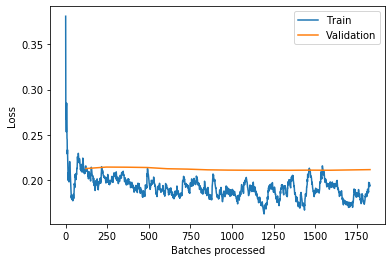

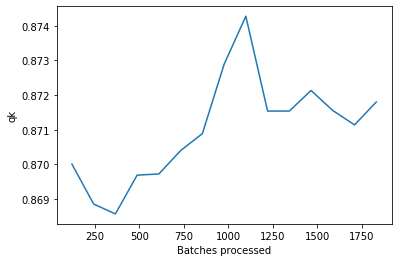

In [30]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [31]:
learn.load(model_save_name)

Learner(data=ImageDataBunch;

Train: LabelList (2929 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,4.0,1.0,0.0,0.0
Path: ../input/aptos2019-blindness-detection;

Valid: LabelList (733 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
1.0,1.0,1.0,2.0,2.0
Path: ../input/aptos2019-blindness-detection;

Test: LabelList (1928 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: ../input/aptos2019-blindness-detection, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleL

## Fold 4

In [9]:
data1 = (ImageList.from_df(df=df_2019_cv,path='../input/aptos2019-blindness-detection',cols='id_code', folder='train_images_ben_preprocessing_sigmaX10', suffix='.png')
        .split_from_df("is_valid4")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

model_name = 'efficientnet-b5'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

learn = Learner(data1, 
                model, 
                path = ".",
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = '../output/models/')

learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

learn.load("efficientnet-b5_0812_22-06-45_stage1")

Loaded pretrained weights for efficientnet-b5


Learner(data=ImageDataBunch;

Train: LabelList (2930 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,4.0,1.0,0.0,0.0
Path: ../input/aptos2019-blindness-detection;

Valid: LabelList (732 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
1.0,1.0,1.0,1.0,1.0
Path: ../input/aptos2019-blindness-detection;

Test: LabelList (1928 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: ../input/aptos2019-blindness-detection, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleL

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.74E-06


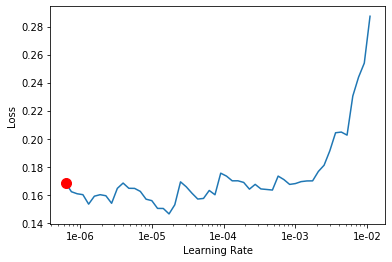

In [39]:
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [10]:
model_save_name = "{}_{}_stage2_f4".format(model_name, current_time)
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(40, 1e-6, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time
0,0.169750,0.229422,0.898727,00:44
1,0.167110,0.229831,0.895655,00:44
2,0.151201,0.230053,0.898438,00:44
3,0.158910,0.229432,0.895655,00:44


Better model found at epoch 0 with valid_loss value: 0.22942191362380981.
Epoch 4: early stopping
Model save as: efficientnet-b5_0821_01-30-37_stage2_f4


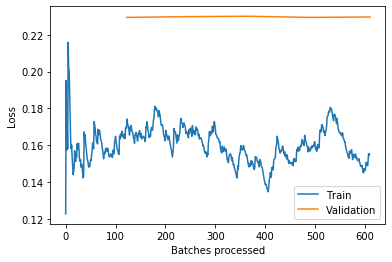

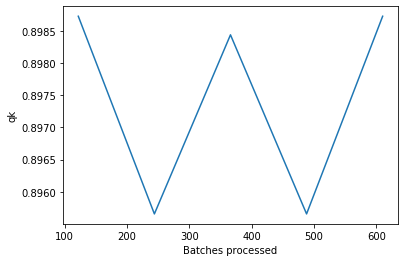

In [11]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [12]:
learn.load(model_save_name)

Learner(data=ImageDataBunch;

Train: LabelList (2930 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,4.0,1.0,0.0,0.0
Path: ../input/aptos2019-blindness-detection;

Valid: LabelList (732 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
1.0,1.0,1.0,1.0,1.0
Path: ../input/aptos2019-blindness-detection;

Test: LabelList (1928 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: ../input/aptos2019-blindness-detection, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleL

## Fold 5

In [8]:
data1 = (ImageList.from_df(df=df_2019_cv,path='../input/aptos2019-blindness-detection',cols='id_code', folder='train_images_ben_preprocessing_sigmaX10', suffix='.png')
        .split_from_df("is_valid5")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

model_name = 'efficientnet-b5'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

learn = Learner(data1, 
                model, 
                path = ".",
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = '../output/models/')

learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

learn.load("efficientnet-b5_0812_22-06-45_stage1")

Loaded pretrained weights for efficientnet-b5


Learner(data=ImageDataBunch;

Train: LabelList (2931 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,4.0,1.0,0.0,0.0
Path: ../input/aptos2019-blindness-detection;

Valid: LabelList (731 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
3.0,1.0,3.0,1.0,2.0
Path: ../input/aptos2019-blindness-detection;

Test: LabelList (1928 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: ../input/aptos2019-blindness-detection, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleL

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-06
Min loss divided by 10: 5.75E-05


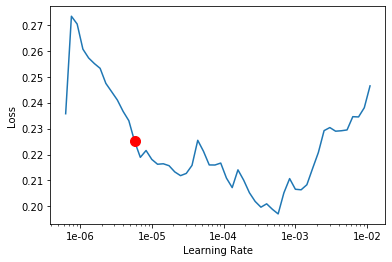

In [16]:
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [17]:
model_save_name = "{}_{}_stage2_f5".format(model_name, current_time)
min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(40, min_grad_lr, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time
0,0.183527,0.222164,0.890835,00:44
1,0.182918,0.222272,0.892051,00:44
2,0.195860,0.222478,0.890958,00:44
3,0.192424,0.222528,0.891436,00:44


Better model found at epoch 0 with valid_loss value: 0.22216422855854034.
Epoch 4: early stopping
Model save as: efficientnet-b5_0821_00-26-51_stage2_f5


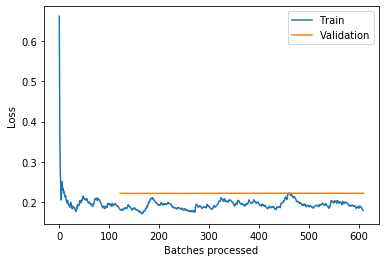

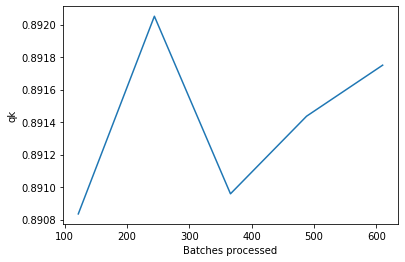

In [18]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [19]:
learn.load(model_save_name)

Learner(data=ImageDataBunch;

Train: LabelList (2931 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,4.0,1.0,0.0,0.0
Path: ../input/aptos2019-blindness-detection;

Valid: LabelList (731 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
3.0,1.0,3.0,1.0,2.0
Path: ../input/aptos2019-blindness-detection;

Test: LabelList (1928 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: ../input/aptos2019-blindness-detection, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleL

## Retrain on whole dataset

In [8]:
data1 = (ImageList.from_df(df=df_2019_cv,path='../input/aptos2019-blindness-detection',cols='id_code', folder='train_images_ben_preprocessing_sigmaX10', suffix='.png')
        .split_none()
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

model_name = 'efficientnet-b5'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

learn = Learner(data1, 
                model, 
                path = ".",
                metrics = [qk],
                model_dir = '../output/models/')

learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

learn.load("efficientnet-b5_0812_22-06-45_stage1")

model_save_name = "{}_{}_stage2_whole".format(model_name, current_time)
learn.fit_one_cycle(4, 2e-4)

Loaded pretrained weights for efficientnet-b5


In [9]:
learn.export("../output/inference/{}.pkl".format(model_save_name))

# Optimize the Metric
Optimizing the quadratic kappa metric was an important part of the top solutions in the previous competition. Thankfully, @abhishek has already provided code to do this for us. We will use this to improve the score.

In [13]:
class OptimizedRounder(object):
    """
    Optimize threshold coefficients.
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Customized loss function.
        
        :param coef: list, shape=[4]
            Threshold.
        :param X: list, shape=[5]
            Prediction.
        :param y: list, shape=[5]
            Golden label.
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        
        # Cohen's kappa: a statistic that measures inter-annotator agreement.
        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        """
        :param X: list, shape=[5]
            Prediction.
        :param y: list, shape=[5]
            Golden label.
        """
        # new function with partial application of the given arguments and keywords.
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        # Minimization of scalar function of one or more variables.
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        """
        :param X: list, shape=[5]
            Prediction.
        :param coef: list, shape=[4]
            Threshold.
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

# Submission

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa7b7230f98>]], dtype=object)

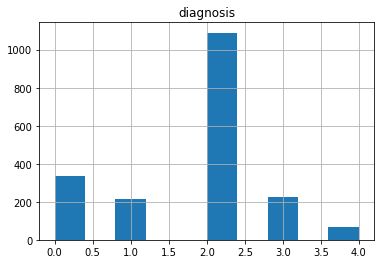

In [10]:
old = pd.read_csv("b5_814.csv")
old.hist()

## Fold 1

efficientnet-b5_0820_01-32-30_stage2_f1_submition.csv done


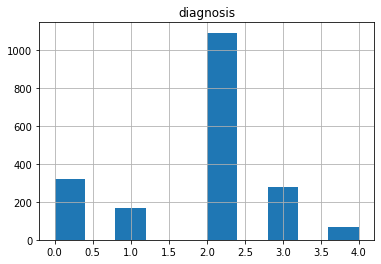

0.9380244678259743

In [25]:
optR = OptimizedRounder()
preds,y = learn.get_preds(DatasetType.Test)
tst_pred = optR.predict(preds, [0.5, 1.5, 2.5, 3.5])
test_df.diagnosis = tst_pred.astype(int)

save_filename = '{}_submition.csv'.format(model_save_name)
test_df.to_csv(save_filename,index=False)
print (save_filename, 'done')

test_df.hist()
plt.show()

old.diagnosis.corr(test_df.diagnosis)

## Fold 2

efficientnet-b5_0820_22-13-07_stage2_f2_submition.csv done


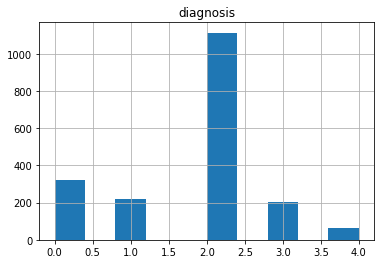

0.972530124506278

In [22]:
optR = OptimizedRounder()
preds,y = learn.get_preds(DatasetType.Test)
tst_pred = optR.predict(preds, [0.5, 1.5, 2.5, 3.5])
test_df.diagnosis = tst_pred.astype(int)

save_filename = '{}_submition.csv'.format(model_save_name)
test_df.to_csv(save_filename,index=False)
print (save_filename, 'done')

test_df.hist()
plt.show()

old.diagnosis.corr(test_df.diagnosis)

## Fold 3

efficientnet-b5_0820_22-13-07_stage2_f3_submition.csv done


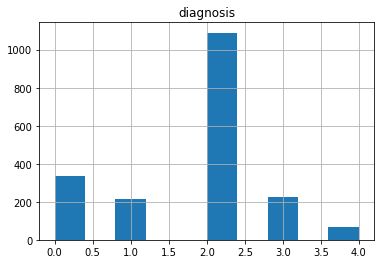

0.9583926403081746

In [33]:
optR = OptimizedRounder()
preds,y = learn.get_preds(DatasetType.Test)
tst_pred = optR.predict(preds, [0.5, 1.5, 2.5, 3.5])
test_df.diagnosis = tst_pred.astype(int)

save_filename = '{}_submition.csv'.format(model_save_name)
test_df.to_csv(save_filename,index=False)
print (save_filename, 'done')

test_df.hist()
plt.show()

old.diagnosis.corr(test_df.diagnosis)

## Fold 4

efficientnet-b5_0821_01-30-37_stage2_f4_submition.csv done


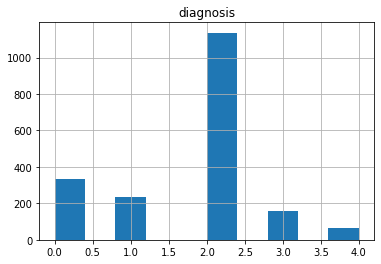

0.9339450990112668

In [15]:
optR = OptimizedRounder()
preds,y = learn.get_preds(DatasetType.Test)
tst_pred = optR.predict(preds, [0.5, 1.5, 2.5, 3.5])
test_df.diagnosis = tst_pred.astype(int)

save_filename = '{}_submition.csv'.format(model_save_name)
test_df.to_csv(save_filename,index=False)
print (save_filename, 'done')

test_df.hist()
plt.show()

old.diagnosis.corr(test_df.diagnosis)

## Fold 5

efficientnet-b5_0821_00-26-51_stage2_f5_submition.csv done


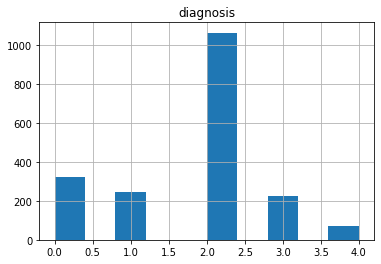

0.9648575999513236

In [24]:
optR = OptimizedRounder()
preds,y = learn.get_preds(DatasetType.Test)
tst_pred = optR.predict(preds, [0.5, 1.5, 2.5, 3.5])
test_df.diagnosis = tst_pred.astype(int)

save_filename = '{}_submition.csv'.format(model_save_name)
test_df.to_csv(save_filename,index=False)
print (save_filename, 'done')

test_df.hist()
plt.show()

old.diagnosis.corr(test_df.diagnosis)

## Whole Data

efficientnet-b5_0823_18-21-16_stage2_whole_submition.csv done


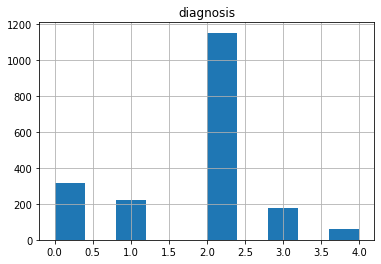

0.9552562607846026

In [11]:
# epoch = 4
preds,y = learn.get_preds(DatasetType.Test)
tst_pred = np.round(preds.numpy())
test_df.diagnosis = tst_pred.astype(int)

save_filename = '{}_submition.csv'.format(model_save_name)
test_df.to_csv(save_filename,index=False)
print (save_filename, 'done')

test_df.hist()
plt.show()

old.diagnosis.corr(test_df.diagnosis)